# Plot transports

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
import cmocean as cm


In [2]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 28,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46769,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:40957,Total threads: 7
Dashboard: /proxy/42829/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:35071,


### Make database

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [4]:
# build database for basal melt experiments:
#session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
session_name ='/g/data/x77/cy8964/databases/basal_melt_MOM5_v2.db'
basal_melt_session = cc.database.create_session(session_name)


In [5]:
# temperature of meltwater using Gade line:
basal = 'accessom2-GPC015'
iceberg = 'accessom2-GPC018'


### First plot contour

In [6]:
### Load Ade?le's isobath contour
isobath_depth = 1000
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']

In [7]:
lat_range = slice(-90,-59)

Text(0.5, 1.0, '1000m isobath contour')

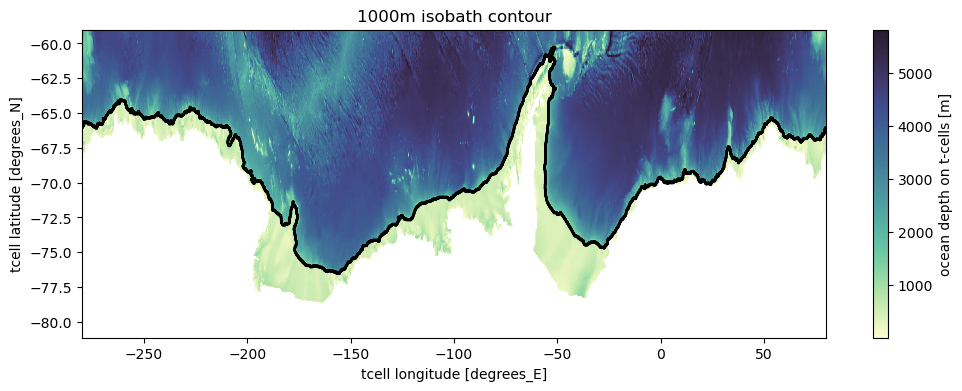

In [8]:
ht = cc.querying.getvar(control, 'ht',master_session, n=1, ncfile = 'ocean_grid.nc')
ht = ht.sel(yt_ocean=lat_range)
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


fig, axes = plt.subplots(figsize = (12,4))
ht.plot(ax = axes, cmap = cm.cm.deep)
axes.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport)+np.abs(mask_y_transport),colors = 'k')
axes.set_title('1000m isobath contour')
#plt.savefig('contour.png', dpi = 300)

### Load contour information

In [9]:
expt = control
session = master_session

In [10]:
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

# ### Stack contour data into 1D

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array



In [11]:
# ## save distance - this takes time

# dxu = cc.querying.getvar(expt,'dxu',session,ncfile = 'ocean_grid.nc',n=1)
# dxu = dxu.sel(yu_ocean = lat_range)
# dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
# dyt = dyt.sel(yt_ocean = lat_range)
# num_points = len(lat_along_contour)
# lat_t = cc.querying.getvar(expt,'geolat_t',session,ncfile = 'ocean_grid.nc',n=1)
# lat_t = lat_t.sel(yt_ocean = lat_range)
# lon_t = cc.querying.getvar(expt,'geolon_t',session,ncfile = 'ocean_grid.nc',n=1)
# lon_t = lon_t.sel(yt_ocean = lat_range)

# # if there is a bend in the contour, add the distance using length of diagonal, not sum of
# # 2 edges, to be more representative.    
# distance_along_contour = np.zeros((num_points))
# x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
# y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])
# skip = False
# for count in range(1,num_points):
#     if skip == True:
#         skip = False
#         continue
#     if count in y_indices:
#         if count + 1 in y_indices:
#             # note dxu and dyt do no vary in x:
#             jj = np.where(mask_y_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dxu[jj,990])[0]
#         else:
#             jj0 = np.where(mask_y_transport_numbered==count)[0]
#             jj1 = np.where(mask_x_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
#                 (dyt[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
#     # count in x_indices:
#     else:
#         if count + 1 in x_indices:
#             jj = np.where(mask_x_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dyt[jj,990])[0]
#         else:
#             jj0 = np.where(mask_x_transport_numbered==count)[0]
#             jj1 = np.where(mask_y_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
#                 (dxu[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
# # fix last value:
# if distance_along_contour[-1] == 0:
#     count = count + 1
#     if count in y_indices:
#         jj = np.where(mask_y_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dxu[jj,990])[0]
#     else:
#         jj = np.where(mask_x_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dyt[jj,990])[0]

# # units are 10^3 km:
# distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3 
# #save_dir = '/g/data/x77/cy8964/Post_Process/access-om2/'
# #ds_latlondist = xr.Dataset({'distance_along_contour': distance_along_contour})
# #ds_latlondist.to_netcdf(save_dir+'1000m_isobath_contour_distance.nc')

In [12]:
distance_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/access-om2/1000m_isobath_contour_distance.nc').distance_along_contour

In [13]:
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1


## Load control transport

In [14]:
## load control transports as a time series

test = xr.open_mfdataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')
vol_trans_across_contour_control = xr.zeros_like(test.vol_trans_across_contour_binned)
vol_trans_across_contour_control  = vol_trans_across_contour_control.expand_dims({"time":np.arange(120)})
vol_trans_across_contour_control_dt_init = []
vol_trans_across_contour_control_dt = xr.zeros_like(test.ndays)
vol_trans_across_contour_control_dt  = vol_trans_across_contour_control_dt.expand_dims({"time":np.arange(120)})
count_days = 0
# load 3 year (3 years x 12 months)
for j in np.arange(2150,2160):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        it.load()
        vol_trans_across_contour_control[i+12*(j-2150)-1,:,:] = it.vol_trans_across_contour_binned 
        vol_trans_across_contour_control_dt_init.append(it.ndays.values) 

vol_trans_across_contour_control_dt = vol_trans_across_contour_control_dt+vol_trans_across_contour_control_dt_init

ds_control = xr.merge([vol_trans_across_contour_control,vol_trans_across_contour_control_dt])
ds_control

<xarray.Dataset>
Dimensions:                          (time: 120, isopycnal_bins: 132,
                                      contour_index: 6002)
Coordinates:
  * time                             (time) int64 0 1 2 3 4 ... 116 117 118 119
  * isopycnal_bins                   (isopycnal_bins) float64 1.0 27.0 ... 40.0
  * contour_index                    (contour_index) int64 1 2 3 ... 6001 6002
Data variables:
    vol_trans_across_contour_binned  (time, isopycnal_bins, contour_index) float64 dask.array<chunksize=(120, 132, 6002), meta=np.ndarray>
    ndays                            (time) int64 31 28 31 30 31 ... 30 31 30 31

In [15]:
def total_mean(ds):
    mean = (ds.vol_trans_across_contour_binned*ds.ndays).sum('time')/ds.ndays.sum('time')
    return mean
def yearly_mean(ds):
    time_len = len(ds.time)
    no_years = int(time_len/12)
    yearly = ds.vol_trans_across_contour_binned.isel(time = np.arange(0,no_years)).rename({'time':'years'})
    for k in range(no_years):
        ds_i = ds.isel(time = np.arange(k*12,(k+1)*12))
        mean = (ds_i.vol_trans_across_contour_binned*ds_i.ndays).sum('time')/ds_i.ndays.sum('time')
        yearly[k,:,:]=mean
    return yearly

## Load perturbation experiment transport

In [16]:
nyears = 10
expt = iceberg

def load_expt_transport(nyears,expt):
    
    test = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/'+expt+'/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')
    vol_trans_across_contour = xr.zeros_like(test.vol_trans_across_contour_binned)
    vol_trans_across_contour  = vol_trans_across_contour.expand_dims({"time":np.arange(nyears*12)})
    vol_trans_across_contour_dt_init = []
    vol_trans_across_contour_dt = xr.zeros_like(test.ndays)
    vol_trans_across_contour_dt  = vol_trans_across_contour_dt.expand_dims({"time":np.arange(nyears*12)})
    count_days = 0
    # load 3 year (3 years x 12 months)
    for j in np.arange(2150,2150+nyears):
        for i in np.arange(1,13):
            it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/'+expt+'/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
            it.load()
            vol_trans_across_contour[i+12*(j-2150)-1,:,:] = it.vol_trans_across_contour_binned 
            vol_trans_across_contour_dt_init.append(it.ndays.values) 

    vol_trans_across_contour_dt = vol_trans_across_contour_dt+vol_trans_across_contour_dt_init

    ds = xr.merge([vol_trans_across_contour,vol_trans_across_contour_dt])
    return ds

vol_trans_across_contour_iceberg = load_expt_transport(10,iceberg)
vol_trans_across_contour_basal = load_expt_transport(10,basal)



## Plot transports

In [23]:
yearly_iceberg

<xarray.DataArray 'vol_trans_across_contour_binned' (years: 10,
                                                     isopycnal_bins: 132)>
dask.array<sum-aggregate, shape=(10, 132), dtype=float64, chunksize=(10, 132), chunktype=numpy.ndarray>
Coordinates:
  * years           (years) int64 0 1 2 3 4 5 6 7 8 9
  * isopycnal_bins  (isopycnal_bins) float64 1.0 27.0 27.1 ... 32.78 32.79 40.0

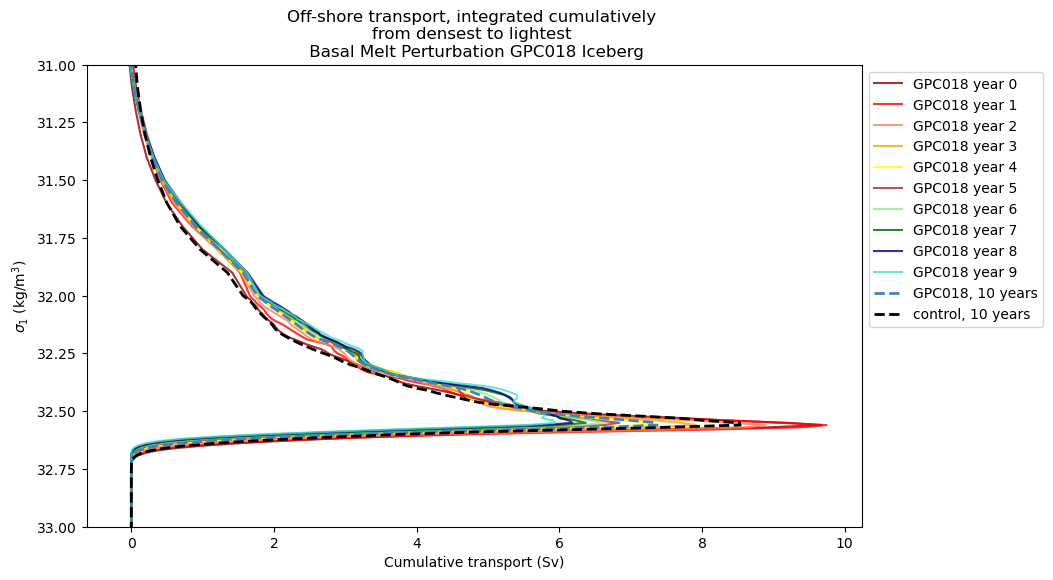

In [27]:
fig = plt.figure(figsize = (10,6))
# plot individual years 
yearly_iceberg = yearly_mean(vol_trans_across_contour_iceberg/1e6).sum('contour_index')
colors = ['darkred','red','coral','orange','yellow','brown','lightgreen','darkgreen','navy','turquoise']
expt_name = 'GPC018'
for i in range(len(yearly_iceberg.years)):
    b = yearly_iceberg.isel(years = i)
    (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = colors[np.mod(i,10)],alpha = 0.8, label = expt_name+' year '+str(i))


# plot mean in blue
b = (total_mean(vol_trans_across_contour_iceberg)/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', label = expt_name+', '+str(len(yearly_iceberg.years))+' years',color = 'steelblue', linestyle = '--',linewidth = 2)
#plot control in black
a = (total_mean(ds_control)/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', label = 'control, 10 years',color = 'k', linestyle = '--',linewidth = 2)

plt.ylim(33,31)
plt.xlabel('Cumulative transport (Sv)')
plt.ylabel('$\sigma_1$ (kg/m$^3$)')
plt.title('Off-shore transport, integrated cumulatively \nfrom densest to lightest \n Basal Melt Perturbation GPC018 Iceberg')
plt.legend(bbox_to_anchor = (1,1), loc = 'upper left')
#plt.savefig('offshore_transport_sum.png',dpi = 300)

In [29]:
ds_control

<xarray.Dataset>
Dimensions:                          (time: 120, isopycnal_bins: 132,
                                      contour_index: 6002)
Coordinates:
  * time                             (time) int64 0 1 2 3 4 ... 116 117 118 119
  * isopycnal_bins                   (isopycnal_bins) float64 1.0 27.0 ... 40.0
  * contour_index                    (contour_index) int64 1 2 3 ... 6001 6002
Data variables:
    vol_trans_across_contour_binned  (time, isopycnal_bins, contour_index) float64 dask.array<chunksize=(120, 132, 6002), meta=np.ndarray>
    ndays                            (time) int64 31 28 31 30 31 ... 30 31 30 31

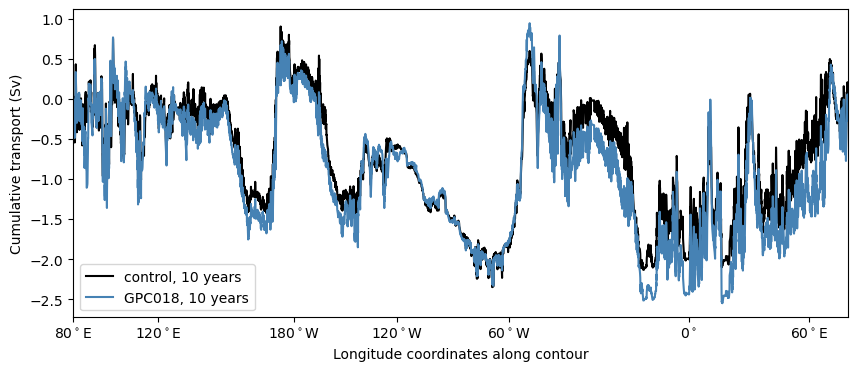

In [31]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*total_mean(ds_control).sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 10 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*total_mean(vol_trans_across_contour_iceberg).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC018, 10 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()


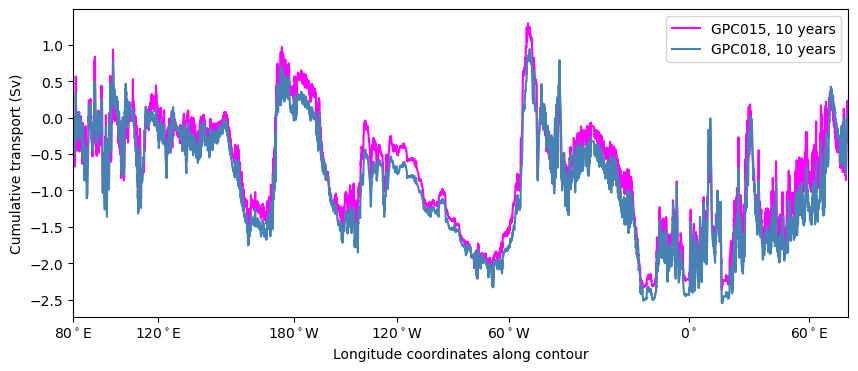

In [40]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*total_mean(vol_trans_across_contour_basal).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC015, 10 years', color = 'magenta')
axes.plot(distance_along_contour,(10**(-6)*total_mean(vol_trans_across_contour_iceberg).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC018, 10 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()


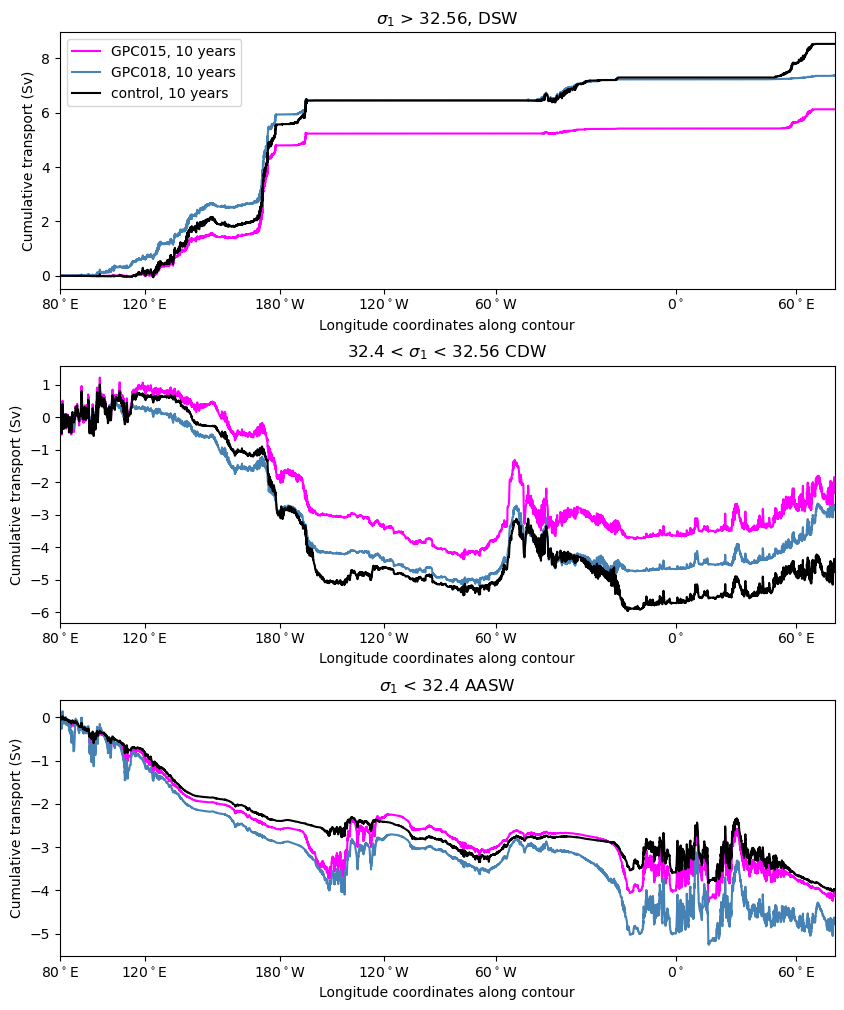

In [18]:
fig, axes = plt.subplots(figsize = (10,12),nrows = 3)

for i in np.arange(3):
    density_range = [slice(32.56,40),slice(32.4,32.56),slice(0,32.4)][i]
    title = ['$\sigma_1$ > 32.56, DSW','32.4 < $\sigma_1$ < 32.56 CDW','$\sigma_1$ < 32.4 AASW' ][i]
                     
    axes[i].plot(distance_along_contour,(10**(-6)*total_mean(vol_trans_across_contour_basal).sel(isopycnal_bins = density_range).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC015, 10 years', color = 'magenta')
    axes[i].plot(distance_along_contour,(10**(-6)*total_mean(vol_trans_across_contour_iceberg).sel(isopycnal_bins = density_range).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC018, 10 years',color = 'steelblue')
    axes[i].plot(distance_along_contour,(10**(-6)*total_mean(ds_control).sel(isopycnal_bins = density_range).sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 10 years',color = 'k')
    axes[i].set_ylabel('Cumulative transport (Sv)')
    axes[i].set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
    axes[i].set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
    axes[i].set_xlim(0,distance_along_contour[-1]);
    axes[i].set_xlabel('Longitude coordinates along contour')
    axes[i].set_title(title)
    
fig.subplots_adjust(hspace = 0.3)
axes[0].legend()


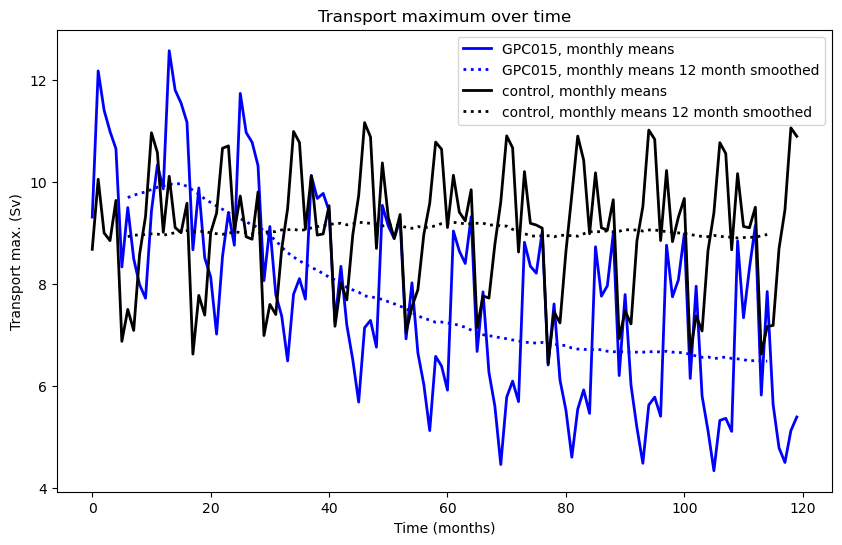

In [32]:
fig = plt.figure(figsize = (10,6))
# plot monthly transport max for perturbation
a = (vol_trans_across_contour_iceberg.vol_trans_across_contour_binned/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).max('isopycnal_bins').plot(label = 'GPC015, monthly means',color = 'b', linewidth = 2)
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).max('isopycnal_bins').rolling(time = 12, center = True).mean().plot(label = 'GPC018, monthly means 12 month smoothed',color = 'b', linewidth = 2, linestyle = 'dotted')
# plot mean transport max for control
#c = (total_mean(ds_control)/1e6).sum('contour_index')
#b = (c.sum('isopycnal_bins') -c.cumsum('isopycnal_bins')).max('isopycnal_bins')
#plt.hlines(b, 0,120, color = 'k', label = 'control, 10 year mean', linestyle = "--")
# plot monthly transport max for control
a = (ds_control.vol_trans_across_contour_binned/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).max('isopycnal_bins').plot(label = 'control, monthly means',color = 'k', linewidth = 2)
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).max('isopycnal_bins').rolling(time = 12, center = True).mean().plot(label = 'control, monthly means 12 month smoothed',color = 'k', linewidth = 2, linestyle = 'dotted')

plt.ylabel('Transport max. (Sv)')
plt.xlabel('Time (months)')
plt.title('Transport maximum over time')
plt.legend()

32.55999999999989


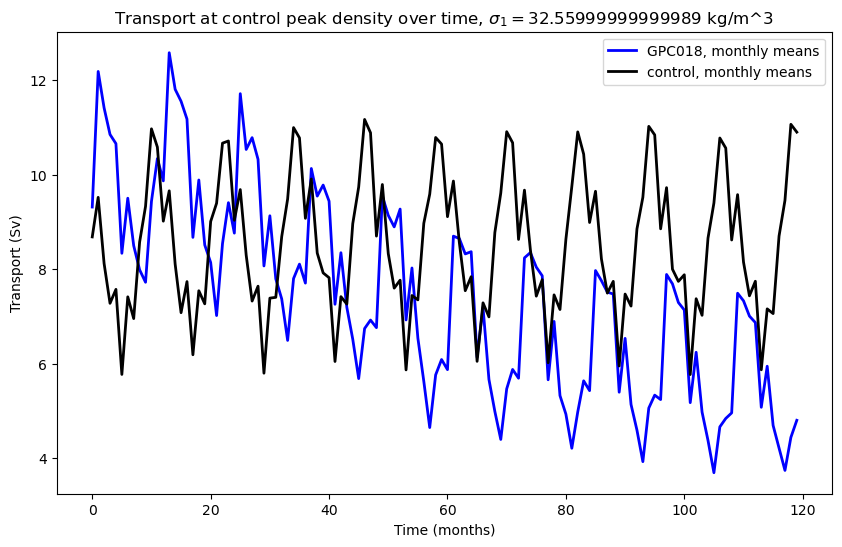

In [35]:
fig = plt.figure(figsize = (10,6))


# find time mean control peak transpformation density
c = (total_mean(ds_control)/1e6).sum('contour_index')
b = (c.sum('isopycnal_bins') -c.cumsum('isopycnal_bins')).idxmax('isopycnal_bins')
a = (vol_trans_across_contour_iceberg.vol_trans_across_contour_binned/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).sel(isopycnal_bins = b.values).plot(label = 'GPC018, monthly means',color = 'b', linewidth = 2)

print(b.values)
# plot monthly transport at control peak transformation density for perturbation
a = (ds_control.vol_trans_across_contour_binned/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).sel(isopycnal_bins = b.values).plot(label = 'control, monthly means',color = 'k', linewidth = 2)


plt.ylabel('Transport (Sv)')
plt.xlabel('Time (months)')
plt.title('Transport at control peak density over time, $\sigma_1 = $'+str(b.values)+' kg/m^3')
plt.legend()

Adelie (-280 to -198)
Longitude range -279.95 to -198.24999999999784
Ross (-198 to -84)
Longitude range -198.24999999999784 to -83.85000000000434
Weddell (-84 to 14)
Longitude range -83.85000000000434 to 14.449999999995105
Prydz (14 to 80)
Longitude range 14.449999999995105 to 80.0


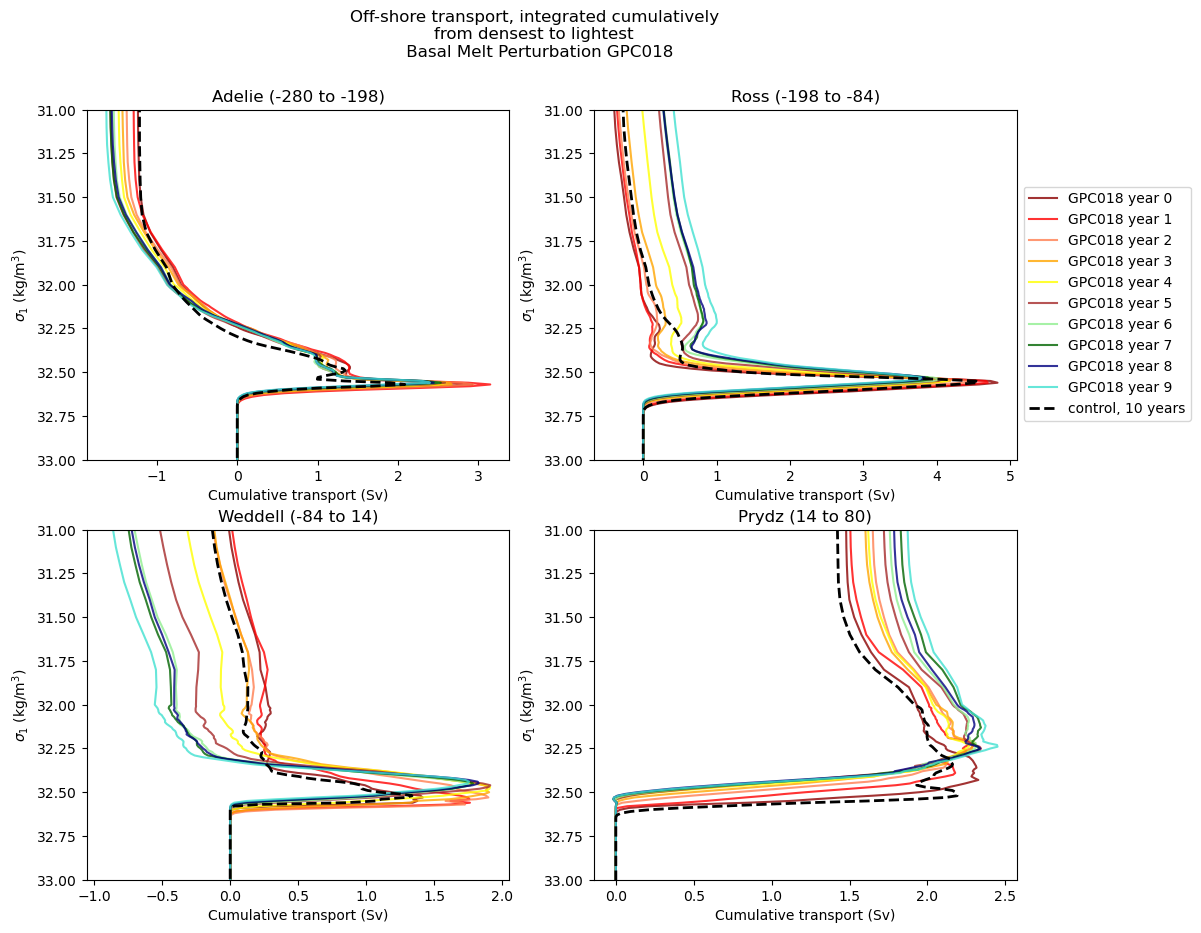

In [19]:
fig,axes = plt.subplots(nrows = 2, ncols = 2,figsize = (12,10))
yearly_iceberg = yearly_mean(vol_trans_across_contour_iceberg/1e6)
colors = ['darkred','red','coral','orange','yellow','brown','lightgreen','darkgreen','navy','turquoise']
expt_name = 'GPC018'

for j in np.arange(4):
    DSW_sector = ['Adelie (-280 to -198)','Ross (-198 to -84)','Weddell (-84 to 14)','Prydz (14 to 80)'][j]
    contour_range_l = [0,1300,3000,5000,6001][j]
    contour_range_r = [0,1300,3000,5000,6001][j+1]
    print(DSW_sector)
    print('Longitude range '+str(lon_along_contour.values[contour_range_l])+ ' to '+str(lon_along_contour.values[contour_range_r]))
    ax = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]][j]

    for i in range(len(yearly_iceberg.years)):
        b = yearly_iceberg.isel(years = i).sel(contour_index = slice(contour_range_l,contour_range_r)).sum('contour_index')
        (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', color = colors[np.mod(i,10)],alpha = 0.8, label = expt_name+' year '+str(i))

    #plot control in black
    a = (total_mean(ds_control)/1e6).sel(contour_index = slice(contour_range_l,contour_range_r)).sum('contour_index')
    (a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', label = 'control, 10 years',color = 'k', linestyle = '--',linewidth = 2)

    ax.set_ylim(33,31)
    ax.set_xlabel('Cumulative transport (Sv)')
    ax.set_ylabel('$\sigma_1$ (kg/m$^3$)')
    ax.set_title(DSW_sector)
fig.suptitle('Off-shore transport, integrated cumulatively \nfrom densest to lightest \n Basal Melt Perturbation GPC018')
axes[1,1].legend(bbox_to_anchor = (1,2), loc = 'upper left')
#plt.savefig('offshore_transport_sum.png',dpi = 300)